# NN Corr #

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl
import sacc
from tjpcov import wigner_transform, bin_cov, parse
import pandas as pd
from astropy.table import Table
from astropy.io import fits
import numpy as np
import itertools 
from itertools import permutations
import clustering_lensing_v5 as cl

In [3]:
d2r = np.pi/180
am2d = 1./60.
wholesky = 4*(180**2)/np.pi #deg_sq
obs_area = 136.9
fsky = obs_area/wholesky

pz_ranges = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, np.inf])
mag_ranges = np.array([17, 18, 19, 20, 21, 22, 23, np.inf])
min_pz = 0
max_pz = 1.5
pz_bin_width = 0.05

l_pz_ranges = pz_ranges[1:-2]
s_pz_ranges = pz_ranges[1:-1]

mag_lim_l = 23
mag_lim_s = 24.5

In [4]:
ccl.__version__

'2.1.0'

In [5]:
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96,transfer_function='eisenstein_hu')

In [6]:
field_name = 'ALL'
main_path = 'Data/{}_main.fits'.format(field_name)
main = cl.main_df_gen(main_path, pz_lim=max_pz)

In [7]:
class Tracer:
    def __init__(self, z, nz):
        self.z = z
        self.nz = nz

In [8]:
class TwoPointData:
    def __init__(self, df, lbins, sbins, l_pz_range, s_pz_range):
        self.df = df
        self.lbins = lbins
        self.sbins = sbins
        self.l_pz_range = l_pz_range
        self.s_pz_range = s_pz_range
        self.tracers = self.get_all_tracers()
        self.metadata = dict()
    
    def lens_names(self):
        names = []
        for i in range(self.lbins):
            names.append('lens{}'.format(i))
        return names
    
    def src_names(self):
        names = []
        for i in range(self.sbins):
            names.append('src{}'.format(i))
        return names
    
    def get_all_tracers(self):
        l_names = self.lens_names()
        s_names = self.src_names()
        df_l = self.df[self.df.imag_forced_cmodel<mag_lim_l]
        df_s = self.df[self.df.imag_forced_cmodel<mag_lim_s]
        tracers = dict()
        for l in range(self.lbins):
            dfw = df_l[df_l.pz_group == self.l_pz_range[l]]
            nz, z= np.histogram(dfw.ephor_photoz_best,
                                bins=np.arange(min_pz, max_pz+pz_bin_width, pz_bin_width), density=True)
            lensTracer = Tracer(z[0:-1], nz)
            tracers[l_names[l]]=lensTracer
        for s in range(self.sbins):
            dfw = df_s[df_s.pz_group == self.s_pz_range[s]]
            nz, z= np.histogram(dfw.ephor_photoz_best,
                                bins=np.arange(min_pz, max_pz+pz_bin_width, pz_bin_width), density=True)
            srcTracer = Tracer(z[0:-1], nz)
            tracers[s_names[s]]=srcTracer
        return tracers
    
    def get_tracer(self, tracer_name):
        return self.tracers[tracer_name]
    
    def get_tracer_combinations(self):
        l_names = self.lens_names()
        s_names = self.src_names()
        combi = []
        # First: the same lens pairs
        for i in range(self.lbins):
            combi.append((l_names[i], l_names[i]))
        # Second: each lens onto each source
        for j in range(self.lbins):
            for k in range(self.sbins):
                combi.append((l_names[j], s_names[k]))
        # Third: all source combi
        for l in range(self.sbins):
            for m in range(self.sbins):
                if m>=l:
                    combi.append((s_names[l], s_names[m]))
        return combi
            
        
twopoint_data = TwoPointData(main, 3, 4, l_pz_ranges, s_pz_ranges)

Now that I have twopoint_data, try changing it to a dictionary

In [9]:
np.sum(twopoint_data.get_tracer('lens0').nz)

20.0

In [10]:
#FIXME: f_sky, ell_bins and th_bins should be passed by sacc. ell0 and th can be decided based on binning or can also be passed by sacc.
twopoint_data.metadata['fsky']=fsky
twopoint_data.metadata['ell']=np.arange(2,500)
twopoint_data.metadata['ell_bins']=np.arange(2,500,20)
th_min=0.1/60 # in degrees
th_max=100./60
n_th_bins=10
twopoint_data.metadata['th_bins']=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)

th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,n_th_bins*30) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
twopoint_data.metadata['th']=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(twopoint_data.metadata['th_bins'][1:]+twopoint_data.metadata['th_bins'][:-1])

In [11]:
thb

array([0.00249605, 0.00498028, 0.00993696, 0.01982685, 0.03955976,
       0.07893209, 0.15749023, 0.31423432, 0.6269799 , 1.25098936])

In [12]:
#The spin based factor to decide the wigner transform. Based on spin of tracers. Sometimes we may use s1_s2 to denote these factors
WT_factors={}
WT_factors['lens','source']=(0,2)
WT_factors['source','lens']=(2,0) #same as (0,2)
WT_factors['source','source']={'plus':(2,2),'minus':(2,-2)}
WT_factors['lens','lens']=(0,0)

In [13]:
#### Wigner Transform setup... 
WT_kwargs={'l': twopoint_data.metadata['ell'],'theta': twopoint_data.metadata['th']*d2r,'s1_s2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 46.9 ms, sys: 2.62 s, total: 2.67 s
Wall time: 3.29 s


In [60]:
twopoint_data.get_tracer_combinations()

[('lens0', 'lens0'),
 ('lens1', 'lens1'),
 ('lens2', 'lens2'),
 ('lens0', 'src0'),
 ('lens0', 'src1'),
 ('lens0', 'src2'),
 ('lens0', 'src3'),
 ('lens1', 'src0'),
 ('lens1', 'src1'),
 ('lens1', 'src2'),
 ('lens1', 'src3'),
 ('lens2', 'src0'),
 ('lens2', 'src1'),
 ('lens2', 'src2'),
 ('lens2', 'src3'),
 ('src0', 'src0'),
 ('src0', 'src1'),
 ('src0', 'src2'),
 ('src0', 'src3'),
 ('src1', 'src1'),
 ('src1', 'src2'),
 ('src1', 'src3'),
 ('src2', 'src2'),
 ('src2', 'src3'),
 ('src3', 'src3')]

In [30]:
a[13]

('lens2', 'src2')

In [15]:
twopoint_data.get_tracer('lens0')

I didn't know what to use for Ngal, sigma_e, b, and AI so I didn't change their values.

In [16]:
#this function will generate and return CCL_tracer objects and also compute the noise for all the tracers
def get_tracer_info(two_point_data={}):
    ccl_tracers={}
    tracer_Noise={}
    for tracer in twopoint_data.tracers:
        tracer_dat=twopoint_data.get_tracer(tracer)
        z= tracer_dat.z
        #FIXME: Following should be read from sacc dataset.
        Ngal = 26. #arc_min^2
        sigma_e=.26
        b = 1.5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
        AI = .5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
        Ngal=Ngal*3600/d2r**2
        
        dNdz = tracer_dat.nz
        dNdz/=(dNdz*np.gradient(z)).sum()
        dNdz*=Ngal
        
        if 'source' in tracer or 'src' in tracer:  
            ccl_tracers[tracer]=ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz),ia_bias=(z,AI)) #CCL automatically normalizes dNdz
            tracer_Noise[tracer]=sigma_e**2/Ngal
        elif 'lens' in tracer:
            tracer_Noise[tracer]=1./Ngal
            ccl_tracers[tracer]=ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    return ccl_tracers,tracer_Noise

In [17]:
def get_cov_WT_spin(tracer_comb=None):
#     tracers=tuple(i.split('_')[0] for i in tracer_comb)
    tracers=[]
    for i in tracer_comb:
        if 'lens' in i:
            tracers+=['lens']
        if 'src' in i:
            tracers+=['source']
    return WT_factors[tuple(tracers)]

In [18]:
#compute a single covariance matrix for a given pair of C_ell or xi.  
def cl_gaussian_cov(tracer_comb1=None,tracer_comb2=None,ccl_tracers=None,tracer_Noise=None,two_point_data=None,do_xi=False,
                    xi_plus_minus1='plus',xi_plus_minus2='plus'):  
    #fsky should be read from the sacc
    #tracers 1,2,3,4=tracer_comb1[0],tracer_comb1[1],tracer_comb2[0],tracer_comb2[1]
    ell=two_point_data.metadata['ell']
    cl={}
    cl[13] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[0]], ell)
    cl[24] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[1]], ell)
    cl[14] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[1]], ell)
    cl[23] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[0]], ell)
    
    SN={}
    SN[13]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[0]  else 0
    SN[24]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[1]  else 0
    SN[14]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[1]  else 0
    SN[23]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[0]  else 0
    
    if do_xi:
        norm=np.pi*4*two_point_data.metadata['fsky']
    else: #do c_ell
        norm=(2*ell+1)*np.gradient(ell)*two_point_data.metadata['fsky']

    coupling_mat={}
    coupling_mat[1324]=np.eye(len(ell)) #placeholder
    coupling_mat[1423]=np.eye(len(ell)) #placeholder
    
    cov={}
    cov[1324]=np.outer(cl[13]+SN[13],cl[24]+SN[24])*coupling_mat[1324]
    cov[1423]=np.outer(cl[14]+SN[14],cl[23]+SN[23])*coupling_mat[1423]
    
    cov['final']=cov[1423]+cov[1324]
    
    if do_xi:
        s1_s2_1=get_cov_WT_spin(tracer_comb=tracer_comb1)
        s1_s2_2=get_cov_WT_spin(tracer_comb=tracer_comb2)
        if isinstance(s1_s2_1,dict):
            s1_s2_1=s1_s2_1[xi_plus_minus1] 
        if isinstance(s1_s2_2,dict):
            s1_s2_2=s1_s2_2[xi_plus_minus2] 
        th,cov['final']=WT.projected_covariance2(l_cl=ell,s1_s2=s1_s2_1, s1_s2_cross=s1_s2_2,
                                                      cl_cov=cov['final'])

    cov['final']/=norm
    
    if do_xi:
        thb,cov['final_b']=bin_cov(r=th/d2r,r_bins=two_point_data.metadata['th_bins'],cov=cov['final']) 
    else:
        if two_point_data.metadata['ell_bins'] is not None:
            lb,cov['final_b']=bin_cov(r=ell,r_bins=two_point_data.metadata['ell_bins'],cov=cov['final']) 
            
#     cov[1324]=None #if want to save memory
#     cov[1423]=None #if want to save memory
    return cov

In [19]:
#compute all the covariances and then combine them into one single giant matrix
def get_all_cov(two_point_data={},do_xi=False):
    #FIXME: Only input needed should be two_point_data, which is the sacc data file. Other parameters should be included within sacc and read from there.
    ccl_tracers,tracer_Noise=get_tracer_info(two_point_data=two_point_data)
    tracer_combs=two_point_data.get_tracer_combinations()# we will loop over all these
    N2pt=len(tracer_combs)
    if two_point_data.metadata['ell_bins'] is not None:
        Nell_bins=len(two_point_data.metadata['ell_bins'])-1
    else:
        Nell_bins=len(two_point_data.metadata['ell'])
    if do_xi:
        Nell_bins=len(two_point_data.metadata['th_bins'])-1
    cov_full=np.zeros((Nell_bins*N2pt,Nell_bins*N2pt))
    for i in np.arange(N2pt):
        print("{}/{}".format(i+1, N2pt))
        tracer_comb1=tracer_combs[i]
        indx_i=i*Nell_bins
        for j in np.arange(i,N2pt):
            tracer_comb2=tracer_combs[j]
            indx_j=j*Nell_bins
            cov_ij=cl_gaussian_cov(tracer_comb1=tracer_comb1,tracer_comb2=tracer_comb2,ccl_tracers=ccl_tracers,
                                        tracer_Noise=tracer_Noise,do_xi=do_xi,two_point_data=two_point_data)
            if do_xi or two_point_data.metadata['ell_bins'] is not None:
                cov_ij=cov_ij['final_b']
            else:
                cov_ij=cov_ij['final']
            cov_full[indx_i:indx_i+Nell_bins,indx_j:indx_j+Nell_bins]=cov_ij
            cov_full[indx_j:indx_j+Nell_bins,indx_i:indx_i+Nell_bins]=cov_ij.T
    return cov_full

In [20]:
#C_ell covariance
cov_cl=get_all_cov(two_point_data=twopoint_data,do_xi=False)
#xi covariance .... right now shear-shear is xi+ only. xi- needs to be added in the loops.
cov_xi=get_all_cov(two_point_data=twopoint_data,do_xi=True)

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


In [21]:
len(cov_xi)

250

(0.0, 600.0, 0.0, 600.0)

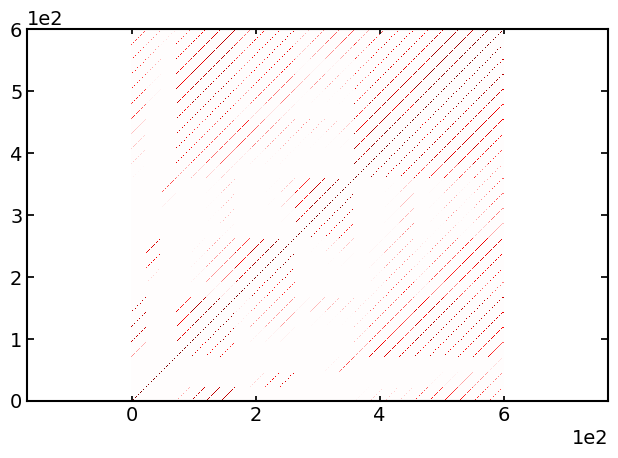

In [22]:
err=np.sqrt(np.diag(cov_cl))
corr_m=cov_cl/np.outer(err,err)
pcolor(corr_m,vmin=-1,vmax=1,cmap='seismic')
axis('equal')

(0.0, 250.0, 0.0, 250.0)

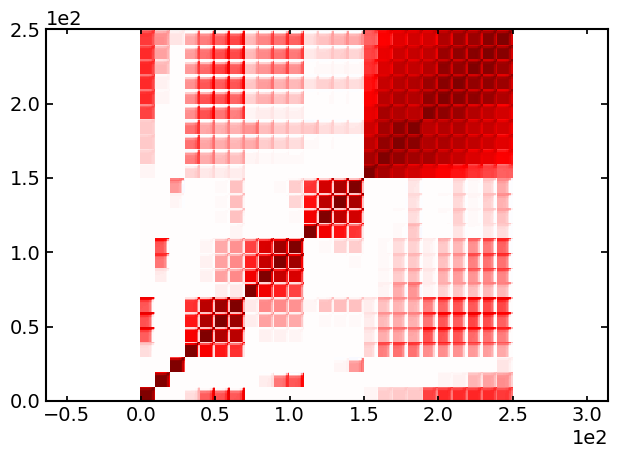

In [23]:
err=np.sqrt(np.diag(cov_xi))
corr_m=cov_xi/np.outer(err,err)
pcolor(corr_m,vmin=-1,vmax=1,cmap='seismic')
axis('equal')

(0.0, 10.0, 0.0, 10.0)

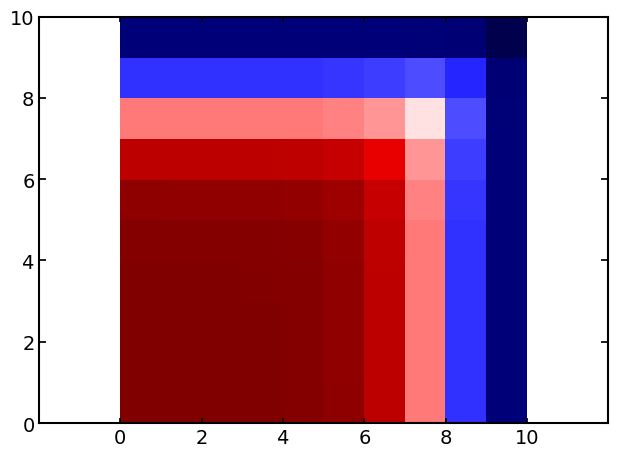

In [65]:
ng0_cov_xi = cov_xi[150:160, 150:160]
pcolor(ng0_cov_xi,cmap='seismic')
axis('equal')

(0.0, 10.0, 0.0, 10.0)

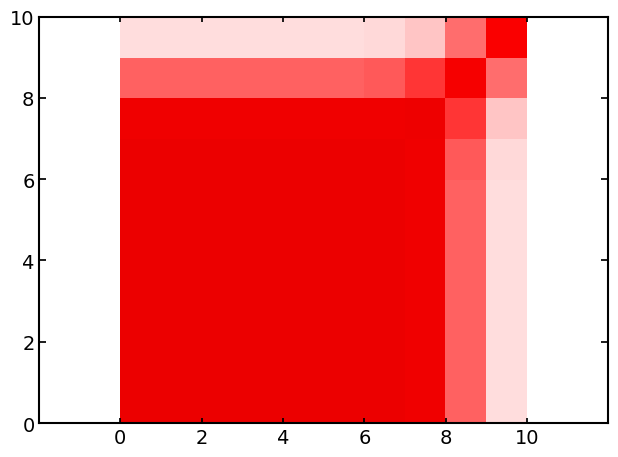

In [56]:
err_0=np.sqrt(np.diag(ng0_cov_xi))
corr_m_0=ng0_cov_xi/np.outer(err,err)
pcolor(corr_m_0,vmin=-1,vmax=1,cmap='seismic')
axis('equal')

In [64]:
ng0_cov_xi

array([[1.00410099e-12, 1.00404697e-12, 1.00383317e-12, 1.00298654e-12,
        9.99645913e-13, 9.86345502e-13, 9.37481268e-13, 7.94228456e-13,
        6.05959862e-13, 4.72904136e-13],
       [1.00404697e-12, 1.00399296e-12, 1.00377921e-12, 1.00293276e-12,
        9.99592866e-13, 9.86295342e-13, 9.37441494e-13, 7.94216289e-13,
        6.05964647e-13, 4.72903480e-13],
       [1.00383317e-12, 1.00377921e-12, 1.00356564e-12, 1.00271993e-12,
        9.99382917e-13, 9.86096821e-13, 9.37284072e-13, 7.94168122e-13,
        6.05983578e-13, 4.72900884e-13],
       [1.00298654e-12, 1.00293276e-12, 1.00271993e-12, 1.00187712e-12,
        9.98551524e-13, 9.85310667e-13, 9.36660622e-13, 7.93977221e-13,
        6.06058497e-13, 4.72890603e-13],
       [9.99645913e-13, 9.99592866e-13, 9.99382917e-13, 9.98551524e-13,
        9.95270943e-13, 9.82208367e-13, 9.34199560e-13, 7.93221372e-13,
        6.06353334e-13, 4.72850034e-13],
       [9.86345502e-13, 9.86295342e-13, 9.86096821e-13, 9.85310667e-13,
   

(0.0, 10.0, 0.0, 10.0)

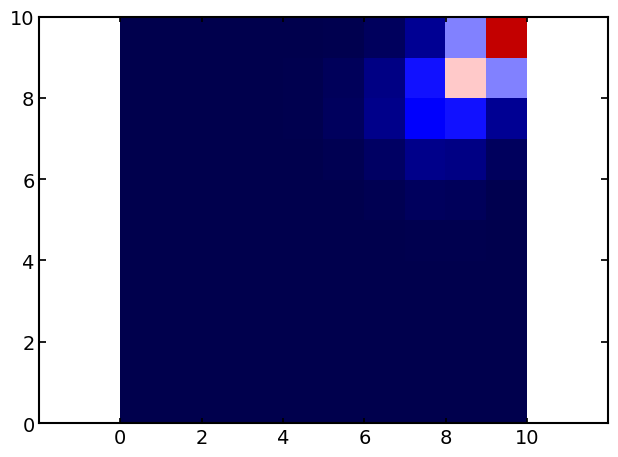

In [54]:
ng1_cov_xi = cov_xi[50:60, 50:60]
pcolor(ng1_cov_xi,vmin=10**(-19),vmax=10**(-9),cmap='seismic')
axis('equal')

(0.0, 10.0, 0.0, 10.0)

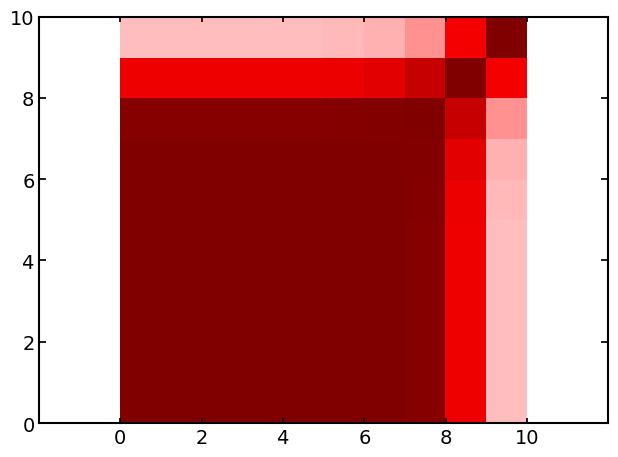

In [57]:
err_1=np.sqrt(np.diag(ng1_cov_xi))
corr_m_1=ng1_cov_xi/np.outer(err,err)
pcolor(corr_m_1,vmin=-1,vmax=1,cmap='seismic')
axis('equal')

In [48]:
ng1_cov_xi

array([[2.56647045e-18, 1.02199266e-17, 4.05057186e-17, 1.60359672e-16,
        6.32079555e-16, 2.49072750e-15, 9.02971577e-15, 2.45548655e-14,
        2.12545680e-14, 6.17029810e-15],
       [1.02199266e-17, 4.06967085e-17, 1.61297580e-16, 6.38567308e-16,
        2.51700049e-15, 9.91831567e-15, 3.59572455e-14, 9.77806001e-14,
        8.46419192e-14, 2.45731204e-14],
       [4.05057186e-17, 1.61297580e-16, 6.39287817e-16, 2.53090179e-15,
        9.97589942e-15, 3.93103847e-14, 1.42514238e-13, 3.87557057e-13,
        3.35536750e-13, 9.74311600e-14],
       [1.60359672e-16, 6.38567308e-16, 2.53090179e-15, 1.00196905e-14,
        3.94940490e-14, 1.55628560e-13, 5.64222064e-13, 1.53451638e-12,
        1.32941323e-12, 3.86319508e-13],
       [6.32079555e-16, 2.51700049e-15, 9.97589942e-15, 3.94940490e-14,
        1.55672300e-13, 6.13449110e-13, 2.22422257e-12, 6.05166231e-12,
        5.25641093e-12, 1.53206994e-12],
       [2.49072750e-15, 9.91831567e-15, 3.93103847e-14, 1.55628560e-13,
   

In [58]:
corr_m_0

array([[0.5739227 , 0.57392197, 0.57391905, 0.57390734, 0.57385893,
        0.57362774, 0.57214934, 0.55535243, 0.30733614, 0.06663766],
       [0.57392197, 0.57392123, 0.57391831, 0.57390662, 0.57385826,
        0.57362727, 0.57214967, 0.55535627, 0.30735126, 0.06664431],
       [0.57391905, 0.57391831, 0.57391541, 0.57390377, 0.57385559,
        0.57362538, 0.57215098, 0.55537147, 0.3074112 , 0.06667067],
       [0.57390734, 0.57390662, 0.57390377, 0.57389232, 0.5738449 ,
        0.57361779, 0.57215603, 0.55543167, 0.30764887, 0.06677527],
       [0.57385893, 0.57385826, 0.57385559, 0.5738449 , 0.57380048,
        0.57358572, 0.57217414, 0.55566888, 0.30859223, 0.06719121],
       [0.57362774, 0.57362727, 0.57362538, 0.57361779, 0.57358572,
        0.57342161, 0.57221618, 0.55661166, 0.3124551 , 0.06890747],
       [0.57214934, 0.57214967, 0.57215098, 0.57215603, 0.57217414,
        0.57221618, 0.57185039, 0.5599299 , 0.3279964 , 0.07602928],
       [0.55535243, 0.55535627, 0.5553714

In [59]:
corr_m_1

array([[1.        , 1.        , 0.99999998, 0.99999971, 0.99999525,
        0.99992077, 0.9986853 , 0.97535414, 0.56386219, 0.13101998],
       [1.        , 1.        , 0.99999999, 0.99999973, 0.99999536,
        0.99992124, 0.9986872 , 0.97536229, 0.56389038, 0.13103285],
       [0.99999998, 0.99999999, 1.        , 0.99999983, 0.9999958 ,
        0.99992307, 0.99869472, 0.97539459, 0.56400208, 0.13108385],
       [0.99999971, 0.99999973, 0.99999983, 1.        , 0.99999732,
        0.99993013, 0.99872432, 0.97552248, 0.56444505, 0.13128618],
       [0.99999525, 0.99999536, 0.9999958 , 0.99999732, 1.        ,
        0.99995482, 0.99883853, 0.9760272 , 0.56620339, 0.13209076],
       [0.99992077, 0.99992124, 0.99992307, 0.99993013, 0.99995482,
        1.        , 0.99925136, 0.97804542, 0.573405  , 0.13541032],
       [0.9986853 , 0.9986872 , 0.99869472, 0.99872432, 0.99883853,
        0.99925136, 1.        , 0.98535869, 0.60240476, 0.14918031],
       [0.97535414, 0.97536229, 0.9753945